In [224]:
import torch
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from law import ScalingLaw

def load_loss(path):
    losses = defaultdict(lambda: defaultdict(dict))   # domain -> ratio
    with open(path, "r") as f:
        lines = set(f.readlines())
    for line in lines:
        model, data, loss = line.split()
        model = model.strip('/')
        step = int(model.split('/')[-1])
        ratio = "-".join(model.split('/')[-2].split('-')[1:])
        subdomain = data.split('/')[-1].split('.')[-2]
        losses[ratio][subdomain][step] = float(loss)
    return losses


with open("valid_weight.json", "r") as f:
    valid_weight = json.load(f)


original_losses = {}
losses = defaultdict(lambda: defaultdict(dict)) 
with open("data/ct/70M.txt", "r") as f:
    for line in f:
        model, data, loss = line.split()

        if 'python' in data:
            subdomain = 'python'
        else:
            subdomain = data.split('/')[-1].split('.')[-2]
        if 'pythia_70m_step20000' in model:
            original_losses[subdomain] = float(loss)
        else:
            model = model.strip('/')
            step = int(model.split('/')[-1])
            ratio = "-".join(model.split('/')[-2].split('-')[1:])
            losses[ratio][subdomain][step] = float(loss)

src_losses = {
    ratio: sum(
        losses[ratio][domain][10000] * w
        for domain, w in valid_weight.items()
    ) 
    for ratio in losses
}
src_original_loss = sum(original_losses[subdomain]*w for subdomain, w in valid_weight.items())

tgt_losses = {
    ratio: losses[ratio]['python'][10000] for ratio in losses
}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 143.27it/s]


8.469416457046464e-07
tensor([-3.7397, -1.6938])
0.28622540757637893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 249.14it/s]


8.927822392479356e-08
tensor([-0.7915, -1.0039])


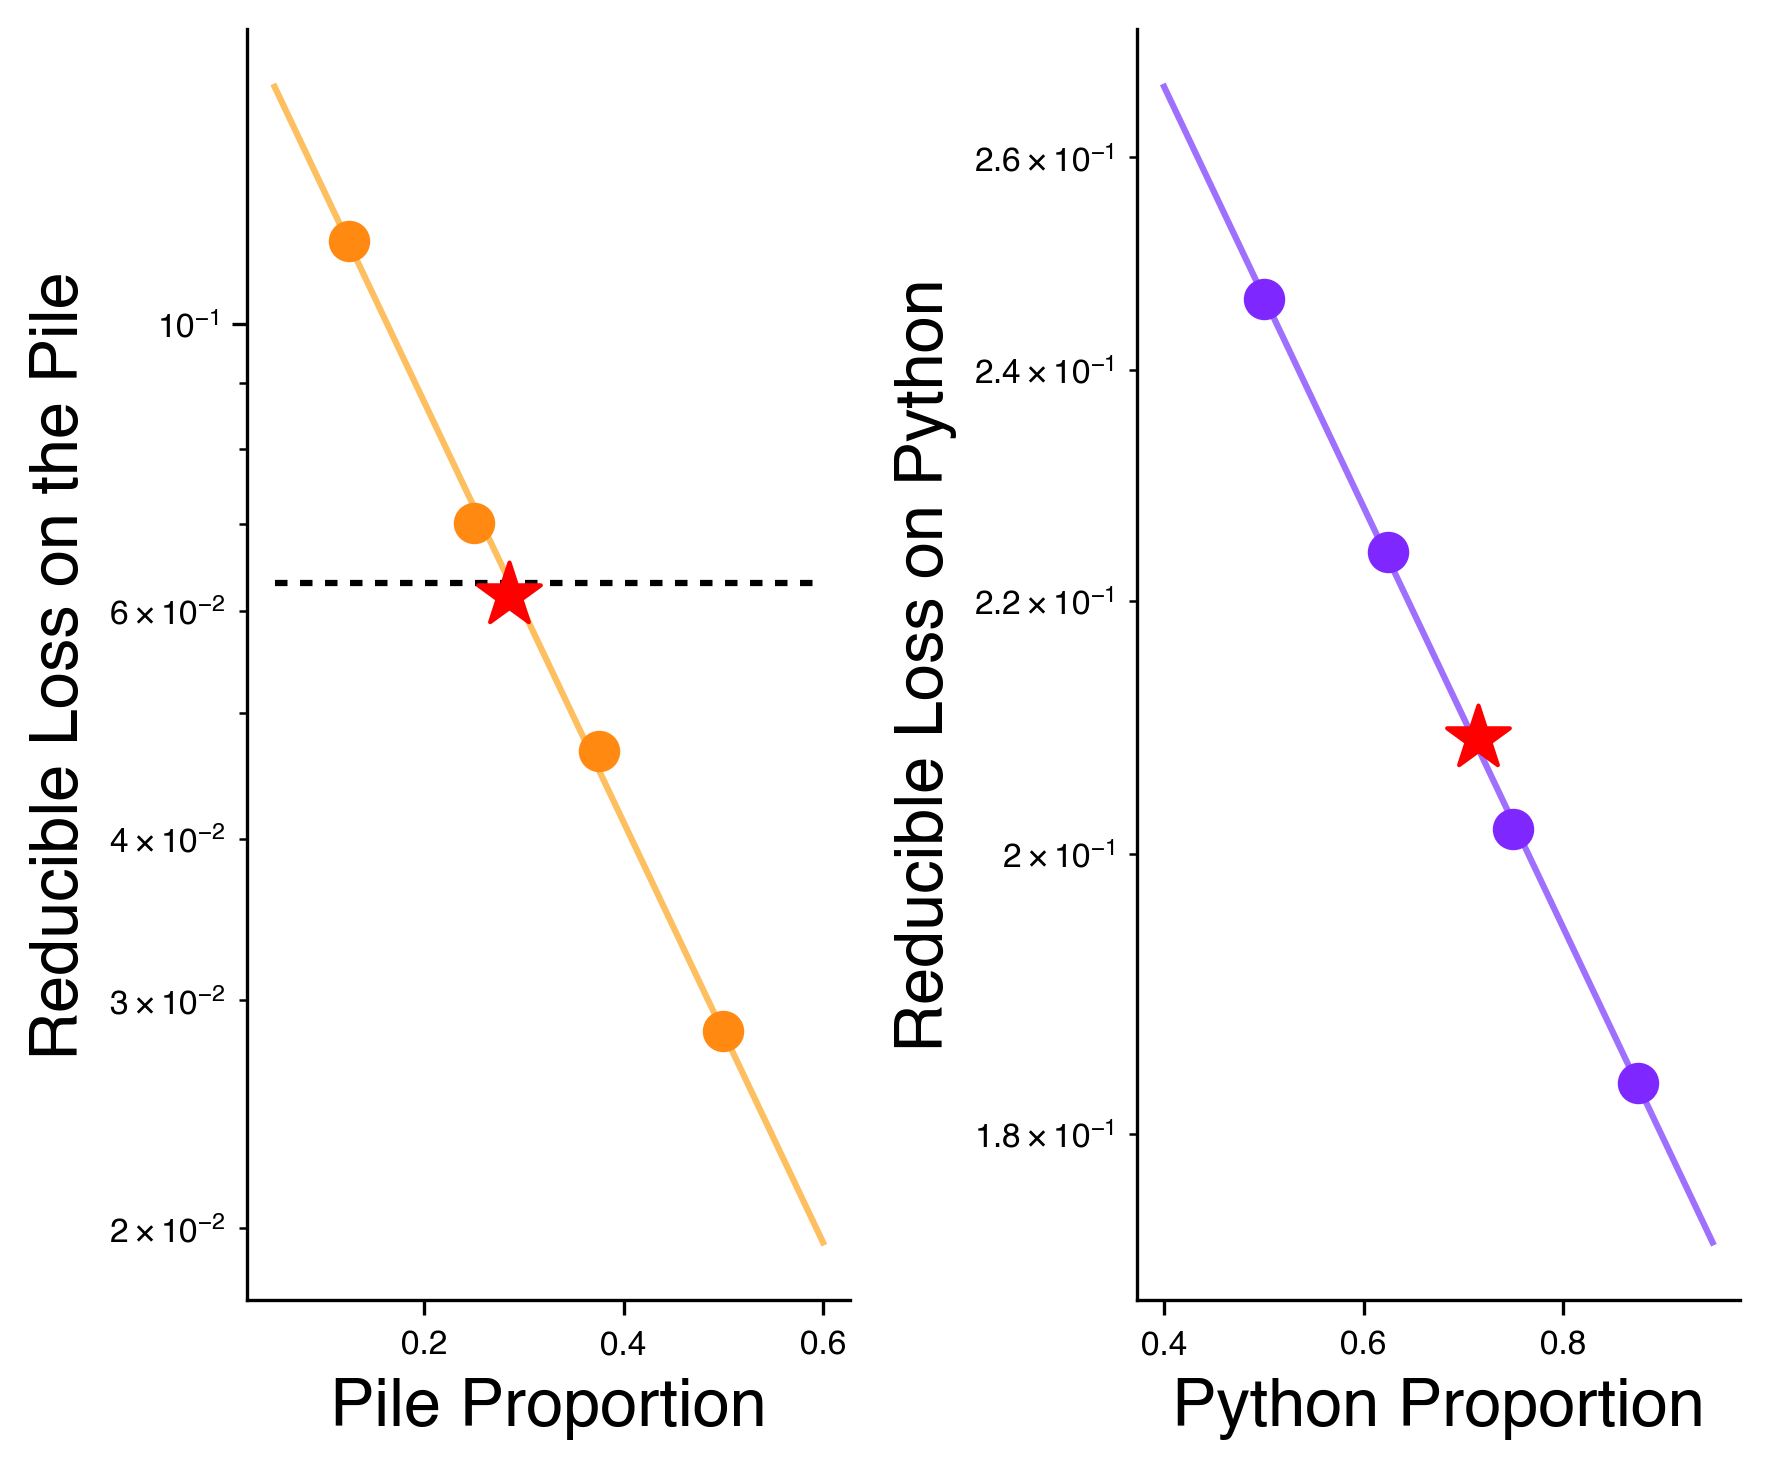

In [233]:
def inter_law(x, param):
    k, b = param
    # y = c + exp(kx+b)
    return torch.exp(k*x + b)

def param_generator():
    for k in np.linspace(-2.4, -1.6, 11):
        for b in np.linspace(-1.0, -0.1, 11):
            yield [k, b]

plt.rcParams['font.family'] = 'Helvetica'  # Set default font family

c1 = np.array([[253, 191, 96], [255, 137, 17]])/255
c2 = np.array([[159, 112, 253], [127, 39, 255]])/255
c = np.array([c1, c2])

fig, axes = plt.subplots(1, 2, figsize=(6, 5), dpi=300)
fig.subplots_adjust(bottom=0.2, top=1)


# src
plot_x = np.linspace(0.05, 0.6, 100)
x = [float(ratio.split('-')[0]) for ratio in src_losses if ratio not in ['0.28515625-0.71484375']]
y = [src_losses[ratio] for ratio in src_losses if ratio not in ['0.28515625-0.71484375']]
best_c, max_corr = 0, 0
for c in np.linspace(0, min(y)-1e-10, 1000):
    corr = np.abs(np.corrcoef(x, np.log(y-c))[0, 1])
    if corr > max_corr:
        max_corr = corr
        best_c = c
law = ScalingLaw(inter_law)
p = law.fit(x, y-best_c, param_generator(), max_step=20, delta=0.02)

axes[0].scatter(x, y-best_c, color=c1[1], s=80) #  label="fitting data")
axes[0].plot(plot_x, inter_law(torch.tensor(plot_x), torch.tensor(p)), color=c1[0], zorder=0) # label="mixture law", 
axes[0].plot([0.05, 0.6], [src_original_loss-best_c, src_original_loss-best_c], dashes=[2, 2], label="w/o continual pretrain", color="black")
axes[0].scatter(
    [0.28515625], [src_losses['0.28515625-0.71484375']-best_c], 
    color="red", marker="*", s=250, label="critical proportion", zorder=999
)
axes[0].tick_params(which="both", labelsize=8)
axes[0].set_yscale("log"); # axes[0].legend(loc="lower left")
axes[0].set_ylabel("Reducible Loss on the Pile", fontsize=16)
axes[0].set_xlabel("Pile Proportion", fontsize=16)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
print((np.log(src_original_loss - best_c) - p[1])/p[0])



x = [float(ratio.split('-')[1]) for ratio in tgt_losses if ratio not in ['0.28515625-0.71484375']]
y = [tgt_losses[ratio] for ratio in tgt_losses if ratio not in ['0.28515625-0.71484375']]
best_c, max_corr = 0, 0
for c in np.linspace(0, min(y)-1e-10, 1000):
    corr = np.abs(np.corrcoef(x, np.log(y-c))[0, 1])
    if corr > max_corr:
        max_corr = corr
        best_c = c
law = ScalingLaw(inter_law)
p = law.fit(x, y-best_c, param_generator(), max_step=20, delta=0.02)

axes[1].scatter(x, y-best_c, color=c2[1], s=80)
axes[1].plot(1-plot_x, inter_law(torch.tensor(1-plot_x), torch.tensor(p)), color=c2[0], zorder=0)
axes[1].scatter(
    [1-0.28515625], [tgt_losses['0.28515625-0.71484375']-best_c], 
    color="red", marker="*", s=250, label="critical point", zorder=999
)
axes[1].tick_params(which="both", labelsize=8)
axes[1].set_ylabel("Reducible Loss on Python", fontsize=16)
axes[1].set_xlabel("Python Proportion", fontsize=16)
axes[1].set_yscale("log")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig("savefigs/continue.png")

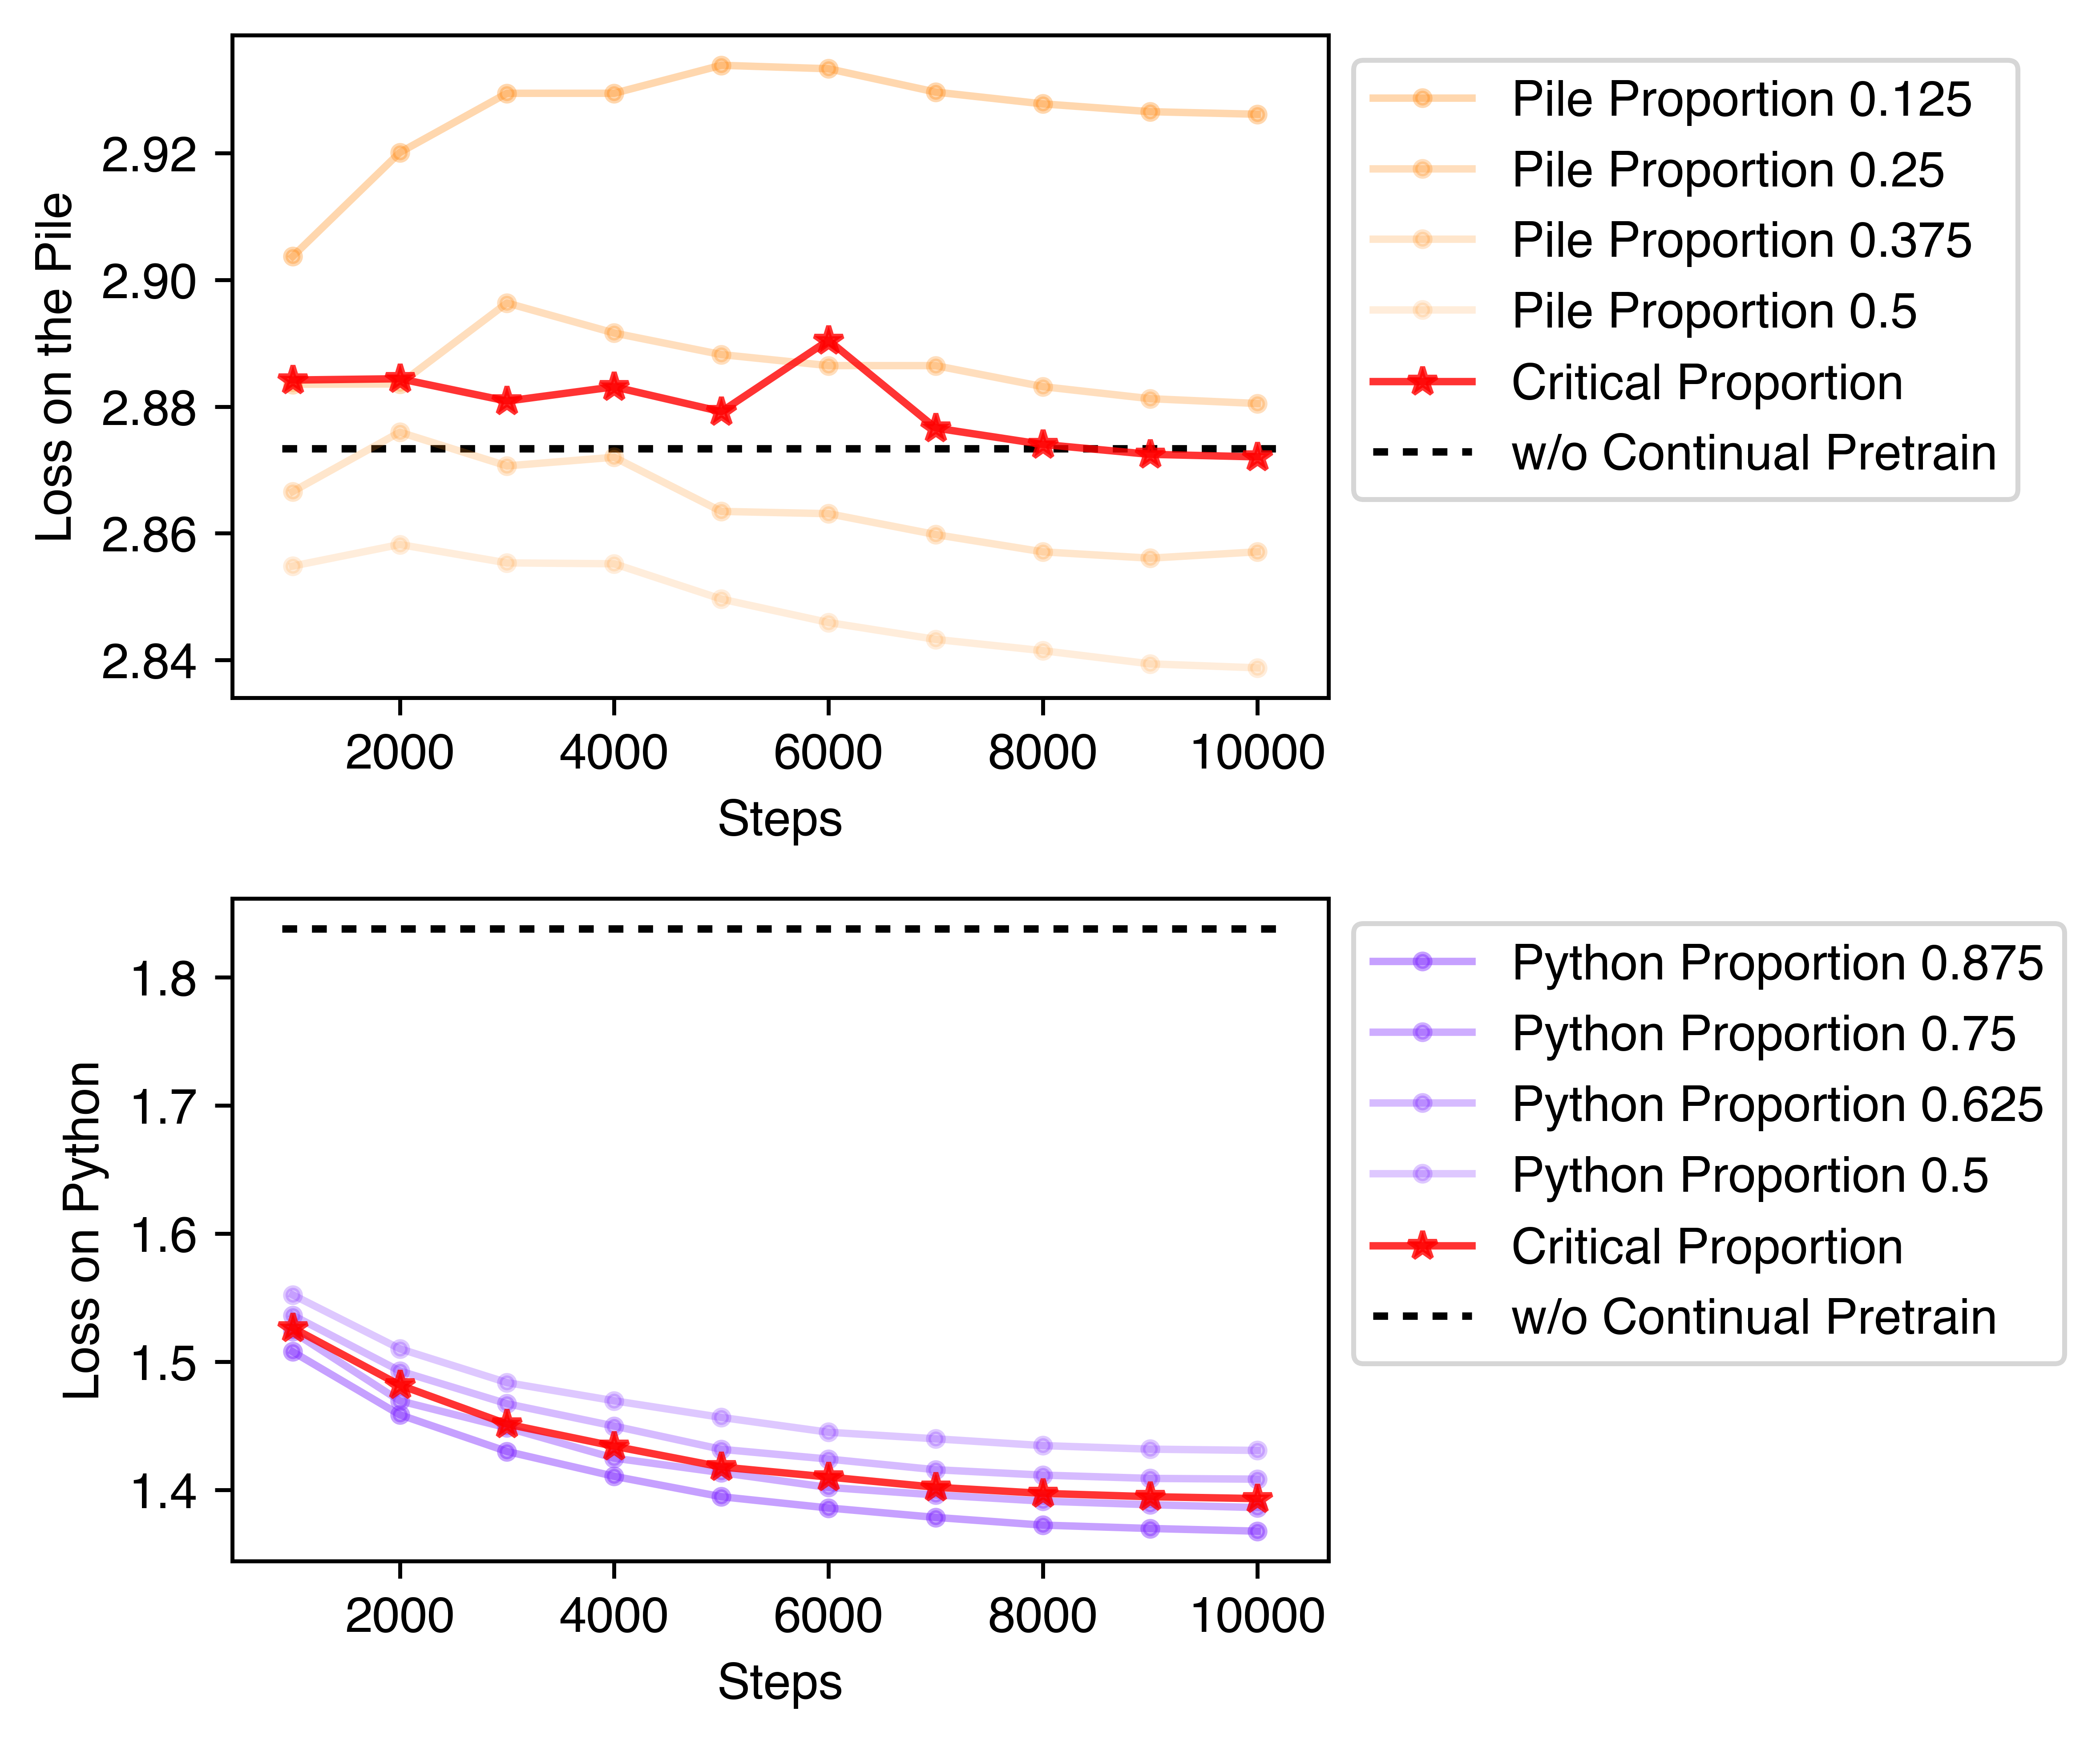

In [231]:
from scipy.interpolate import make_interp_spline, BSpline

fig, axes = plt.subplots(2, 1, figsize=(6, 5), dpi=800)

for ratio in ['0.125-0.875', '0.25-0.75', '0.375-0.625', '0.5-0.5', "0.28515625-0.71484375"]:
    steps = list(range(1000, 10001, 1000))
    loss = [
        sum(losses[ratio][domain][step] * w for domain, w in valid_weight.items())
        for step in steps
    ]
    if ratio != "0.28515625-0.71484375":
        x = np.linspace(0, 10000, 300)
        spl =  make_interp_spline(steps, loss, k=3)
        smooth = spl(x)
        axes[0].plot(steps, loss, marker=".", c=c1[1], alpha=0.4-0.5*float(ratio.split('-')[0]), label="Pile Proportion "+str(round(float(ratio.split('-')[0]), 3)))
        # axes[0].plot(x, smooth, c=c1[1], alpha=0.8-float(ratio.split('-')[0]), label="Pile Proportion "+str(round(float(ratio.split('-')[0]), 3)))
    else:
        axes[0].plot(steps, loss, marker="*", c="red", alpha=0.8, label="Critical Proportion")
axes[0].plot([900, 10200], [src_original_loss, src_original_loss], dashes=[2, 2], zorder=-1, color="black", label="w/o Continual Pretrain")
axes[0].legend(bbox_to_anchor=(1, 1))
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Loss on the Pile")
# axes[0].set_title("Pile (original domain)")
    
tgt_original_loss = original_losses["python"]
for ratio in ['0.125-0.875', '0.25-0.75', '0.375-0.625', '0.5-0.5', "0.28515625-0.71484375"]:
    steps = list(range(1000, 10001, 1000))
    loss = [losses[ratio]["python"][step] for step in steps]
    if ratio != "0.28515625-0.71484375":
        x = np.linspace(0, 10000, 300)
        spl =  make_interp_spline(steps, loss, k=3)
        smooth = spl(x)
        axes[1].plot(steps, loss, marker=".", c=c2[1], alpha=0.5 * float(ratio.split('-')[1]), label="Python Proportion "+str(round(float(ratio.split('-')[1]), 3)))
        # axes[0].plot(x, smooth, c=c1[1], alpha=0.8-float(ratio.split('-')[0]), label="Pile Proportion "+str(round(float(ratio.split('-')[0]), 3)))
    else:
        axes[1].plot(steps, loss, marker="*", c="red", alpha=0.8, label="Critical Proportion")
axes[1].plot([900, 10200], [tgt_original_loss, tgt_original_loss], dashes=[2, 2], zorder=-1, color="black", label="w/o Continual Pretrain")
axes[1].legend(bbox_to_anchor=(1, 1))
axes[1].set_xlabel("Steps")
axes[1].set_ylabel("Loss on Python")
# axes[1].set_title("Python (target domain)")
# plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig("savefigs/loss_steps.png")

In [161]:
spl

In [189]:
original_losses

{'Github': 1.5652903197747976,
 'Pile-CC': 3.602944563882064,
 'Books3': 3.4802782012195124,
 'PhilPapers': 3.7280649038461537,
 'OpenWebText2': 3.5030127992021276,
 'PubMed_Abstracts': 3.0860792590725805,
 'DM_Mathematics': 1.5273088727678572,
 'PG19': 3.5633544921875,
 'FreeLaw': 2.6812666223404253,
 'HackerNews': 3.479029605263158,
 'EuroParl': 2.9779575892857144,
 'OpenSubtitles': 3.1416015625,
 'PubMed_Central': 2.530678077980324,
 'Wikipedia_en': 3.203920344716495,
 'StackExchange': 2.5174347137237763,
 'BookCorpus2': 3.448459201388889,
 'Enron_Emails': 3.0670572916666665,
 'NIH_ExPorter': 3.3341796875,
 'YoutubeSubtitles': 2.595068359375,
 'Ubuntu_IRC': 2.55419921875,
 'ArXiv': 2.2259040601325757,
 'USPTO_Backgrounds': 2.8826805320945947}